### Multimodal RAG
is an enhancement of traditional Retrieval-Augmented Generation (RAG) that goes beyond text to handle and reason over multiple data types—such as images, audio, video, and structured data—alongside text.

Instead of retrieving only text passages, multimodal RAG systems use specialized models (e.g., vision-language models) to encode different data formats into a shared embedding space. This allows the system to retrieve relevant multimodal information and generate responses that integrate insights across modalities—for example, answering questions about a chart, describing events in a video, or summarizing a document with diagrams.
- PymuPDFLoader : better results accordings to others
- CLIP : Contrastive Language-Image Pre-training (CLIP) is a technique for training a pair of neural network models, one for image understanding and one for text understanding, using a contrastive objective.

In [3]:
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_classic.retrievers import EnsembleRetriever
from langchain_core.documents import Document
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
import fitz  # PyMuPDF
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import numpy as np
from langchain_core.messages import HumanMessage
from sklearn.metrics.pairwise import cosine_similarity
import os
import base64
import io
# chain creation
from langchain_classic.chains import create_retrieval_chain
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_classic.chains.combine_documents import create_stuff_documents_chain
from langchain_core.output_parsers import StrOutputParser
from langchain.chat_models import init_chat_model
from langchain_groq import ChatGroq
from dotenv import load_dotenv

In [2]:
# Required pakages for Colab in VS code
! pip install pandas openpyxl langchain-groq langchain==1.2 faiss-cpu langchain-community sentence-transformers pymupdf langchain-huggingface langchain-text-splitters python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [4]:
# This is a multi-lingual version of the OpenAI CLIP-ViT-B32 model.
model_name = "openai/clip-vit-base-patch16"

clip_model = CLIPModel.from_pretrained(model_name)
clip_processor = CLIPProcessor.from_pretrained(model_name)
clip_model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [5]:
# embedding functions
def embed_image(image_data):
    """using CLIP"""
    if isinstance(image_data, str):  # If path
        image = Image.open(image_data).convert("RGB")
    else:  # If PIL Image
        image = image_data

    inputs=clip_processor(
        images=image,
        return_tensors="pt"
        )
    with torch.no_grad():
        features = clip_model.get_image_features(**inputs)
        # Normalize embeddings to unit vector
        features = features / features.norm(dim=-1, keepdim=True)
        return features.squeeze().numpy()

def embed_text(text):
    """using CLIP."""
    inputs = clip_processor(
        text=text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=77  # CLIP's max token length
    )
    with torch.no_grad():
        features = clip_model.get_text_features(**inputs)
        # Normalize embeddings
        features = features / features.norm(dim=-1, keepdim=True)
        return features.squeeze().numpy()

In [10]:
# Process PDF
pdf_path2="/content/drive/MyDrive/jobvision-education-field-selection-guide-1404-part-2.pdf" # metology statistics
pdf_path1="/content/drive/MyDrive/jobvision-education-field-selection-guide-1404-part-1.pdf" # overall statistics
doc=fitz.open(pdf_path2)
# Storage for all documents and embeddings
all_docs = []
all_embeddings = []
image_data_store = {}  # Store actual image data for LLM

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
print(os.listdir('/content'))


['.config', 'drive', 'sample_data']


In [11]:
print(doc[14].get_text())
print(doc[14].get_images(full=True)[0])

 گزارش راهنمای انتخاب رشته۱۴۰۴
209 |   jobvision.ir gozine2.ir maktabkhooneh.org
راه های ارتباطی
شناسه صححه اینتتاگاام:
 job-vision 
 ددر  لننکدی:
 www.linkedin.com/company/job-vision-ir 
 ایمنل ارتباط با تن  تحزنل و تهنه کننده ی گزارش:
       reports@jobvision.ir 
آدرس وب سایت:
jobvision.ir شناسه کانال تلگرام:
t.me/jobvision
ددر  وب سایت:
  jobvision.ir 
شناسه کانال تزگاام:
  t.me/jobvision 

(842, 0, 2912, 1632, 8, 'DeviceRGB', '', 'Image1985', 'DCTDecode', 0)


In [12]:
doc.extract_image(doc[14].get_images(full=True)[0][0])

{'width': 2912,
 'height': 1632,
 'ext': 'jpeg',
 'colorspace': 3,
 'xres': 96,
 'yres': 96,
 'bpc': 8,
 'size': 279220,
 'image': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xe1\x00ZExif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x05\x03\x01\x00\x05\x00\x00\x00\x01\x00\x00\x00J\x03\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x00Q\x10\x00\x01\x00\x00\x00\x01\x01\x00\x00\x00Q\x11\x00\x04\x00\x00\x00\x01\x00\x00\x0e\xc3Q\x12\x00\x04\x00\x00\x00\x01\x00\x00\x0e\xc3\x00\x00\x00\x00\x00\x01\x86\xa0\x00\x00\xb1\x8f\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x06`\x0b`\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07

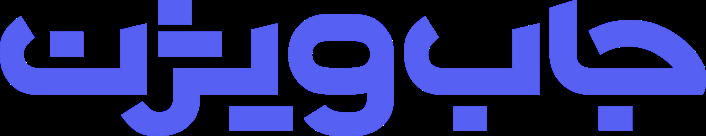

In [13]:
Image.open(io.BytesIO(doc.extract_image(doc[13].get_images(full=True)[2][0])['image'])).convert("RGB") #[2] is counter [0] is RGB [1] is B&W

In [14]:
for i,page in enumerate(doc):
    ## process text
    text=page.get_text()
    if text.strip():
        ##create temporary document for splitting
        temp_doc = Document(page_content=text, metadata={"page": i, "type": "text"})
        text_chunks = splitter.split_documents([temp_doc])

        #Embed each chunk using CLIP
        for chunk in text_chunks:
            embedding = embed_text(chunk.page_content)
            all_embeddings.append(embedding)
            all_docs.append(chunk)



    ## process images
    ##Three Important Actions:

    ##Convert PDF image to PIL format
    ##Store as base64 for GPT-4V (which needs base64 images)
    ##Create CLIP embedding for retrieval

    for img_index, img in enumerate(page.get_images(full=True)):
        try:
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"] # extract sth like b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01...

            # Convert to PIL Image
            pil_image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

            # Create unique identifier
            image_id = f"page_{i}_img_{img_index}"

            # Store image as base64 for later use with GPT4
            buffered = io.BytesIO()
            pil_image.save(buffered, format="PNG")
            img_base64 = base64.b64encode(buffered.getvalue()).decode()
            image_data_store[image_id] = img_base64

            # Embed image using CLIP
            embedding = embed_image(pil_image)
            all_embeddings.append(embedding)

            # Create document for image
            image_doc = Document(
                page_content=f"[Image: {image_id}]",
                metadata={"page": i, "type": "image", "image_id": image_id}
            )
            all_docs.append(image_doc)

        except Exception as e:
            print(f"Error processing image {img_index} on page {i}: {e}")
            continue

doc.close()


In [15]:
embeddings_array = np.array(all_embeddings)

In [16]:
# Create custom FAISS index since we have precomputed embeddings
vector_store = FAISS.from_embeddings(
    text_embeddings=[(doc.page_content, emb) for doc, emb in zip(all_docs, embeddings_array)],
    embedding=None,  # We are using precomputed embeddings
    metadatas=[doc.metadata for doc in all_docs]
)
vector_store

In [20]:
# initialize chat model
from google.colab import userdata
groq_api = userdata.get('GROQ_API')
groq_llm = ChatGroq(model="llama-3.1-8b-instant",api_key=groq_api ,temperature=0.2)

In [33]:
def retriever (query,k=5):
    # Embed Query using CLIP
    query_embedding = embed_text(query)
    # Search by vector
    results = vector_store.similarity_search_by_vector(
        embedding=query_embedding,
        k=k
    )
    return results

In [26]:
def create_multimodal_message(query, retrieved_docs):
    """Create a message with both text and images for GPT-4V."""
    content = []

    # Add the query
    content.append({
        "type": "text",
        "text": f"Question: {query}\n\nContext:\n"
    })
    print(retrieved_docs[0])
    # Separate text and image documents
    text_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "text"]
    image_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "image"]

    # Add text context
    if text_docs:
        text_context = "\n\n".join([
            f"[Page {doc.metadata['page']}]: {doc.page_content}"
            for doc in text_docs
        ])
        content.append({
            "type": "text",
            "text": f"Text excerpts:\n{text_context}\n"
        })

    # Add images
    for doc in image_docs:
        image_id = doc.metadata.get("image_id") # get page and image number
        if image_id and image_id in image_data_store:
            content.append({
                "type": "text",
                "text": f"\n[Image from page {doc.metadata['page']}]:\n"
            })
            content.append({
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{image_data_store[image_id]}"
                }
            })

    # Add instruction
    content.append({
        "type": "text",
        "text": "\n\nPlease answer the question based on the provided text and images."
    })

    return HumanMessage(content=content)

In [34]:
def multimodal_pdf_rag_pipeline(query):
    """Main pipeline for multimodal RAG."""
    context_docs = retriever(query, k=5)
    print(context_docs)
    # Create multimodal message
    message = create_multimodal_message(query, context_docs)

    # Get response from GPT-4V
    response = groq_llm.invoke([message])

    # Print retrieved context info
    print(f"\nRetrieved {len(context_docs)} documents:")
    for doc in context_docs:
        doc_type = doc.metadata.get("type", "unknown")
        page = doc.metadata.get("page", "?")
        if doc_type == "text":
            preview = doc.page_content[:100] + "..." if len(doc.page_content) > 100 else doc.page_content
            print(f"  - Text from page {page}: {preview}")
        else:
            print(f"  - Image from page {page}")
    print("\n")

    return response.content

In [39]:
if __name__ == "__main__":
    # Queries
    queries = [
        "از چه منابعی برای جمع آوری این مقاله استفاده شده",
        "یک خلاصه از جامعه آماری بده که مثلا چند درصد مرد هستند (جنسیت آماری) و بیشتر اهل چه شهر هایی هستند",
        "آیا گزینه دو همکاری داشته"
    ]

    for query in queries:
        print(f"\nQuery: {query}")
        print("-" * 50)
        answer = multimodal_pdf_rag_pipeline(query)
        print(f"Answer: {answer}")
        print("=" * 70)


Query: از چه منابعی برای جمع آوری این مقاله استفاده شده
--------------------------------------------------
[Document(id='8c303047-97f8-428d-83e7-c6ca07e633be', metadata={'page': 11, 'type': 'text'}, page_content='اهی بنشتای ببخشن .به عنوا  یک شاکت کاریابی دنشی ، هدف ما\nاییی  اسییت کییه بییا ارائییه اطشعییات مبتنییی بییا داده هییای بییازار کییار، بییه افییااد کمییک کنیین  تییا تصییمنماتی هوشییمندانه و دگاهانییه بگنانیید کییه بییه رضییایت\nطییو\nالنی مییدت د  هییا کمییک کنیید.\n ما باور داری  که«هاکتی لاانت یک شغل خوب را دارد »\n و در متنا دستاابی به ای  رویا از ها کاری که از دستما  با بااید را انجام می دهن .انتشار ای  گزارش همگام با ای  رسالت است، زیا ا باور داری  که'), Document(id='c46a18fe-02ae-4687-a3e3-4a4601b5c955', metadata={'page': 9, 'type': 'text'}, page_content='تماکز ما با مداارهایی مانند حقوق و رضایت فارغ التحصنش  بوده است .ای  مداارها نابل اندازه گنای و رتبه بندی هتتند، در حالی که عشنه و استدداد به دلنل ماهنت فادی شا ، نمی ت وانند به صورت کزیی\nدر نالب شاخص های مشخص باای 

In [ ]:
# problems to be solve later
# 1. pdf has clickable parts and bars of statistics are not image == try to implement raw file first
# 1. fitz is not a good persian doc loader == replace it or change persian text encode
# 2. pdf has clickable parts and bars of statistics are not image == try to implement raw file first